In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

In [19]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=0.25)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 5 * 5, 128)  # Adapter la taille selon la sortie des convolutions
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 64 * 5 * 5)  # Redimensionner pour la couche entièrement connectée
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)        

In [20]:
def load_model(architecture, model_path):
    model = architecture()  # Créer une instance du modèle
    model.load_state_dict(torch.load(model_path))  # Charger les poids sauvegardés
    model.eval()  # Mettre le modèle en mode évaluation
    return model

# Chemin du fichier contenant les poids sauvegardés
model_path = "models/mnist_cnn.pth"

# Charger le modèle avec les poids sauvegardés
model = load_model(MNIST_Net, model_path)

In [49]:
# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0,), (1,))  # Normalize images
])

download = False

# Load MNIST dataset
train_set = datasets.MNIST(root='./data/', train=True, download=download, transform=transform)
test_set = datasets.MNIST(root='./data/', train=False, download=download, transform=transform)

# Function to split dataset by all classes in one pass
def split_by_all_classes(dataset, num_classes=10):
    class_indices = [[] for _ in range(num_classes)]  # List of lists to hold indices for each class

    # Iterate once through the dataset to collect indices for each class
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    # Create DataLoaders for each class
    data_loaders = [DataLoader(Subset(dataset, indices), batch_size=batch_size, shuffle=True, num_workers=0)
                    for indices in class_indices]
    
    return data_loaders

# Batch size
batch_size = 1000

# Split training and test sets by all classes using the optimized approach
train_loaders = split_by_all_classes(train_set)
test_loaders = split_by_all_classes(test_set)

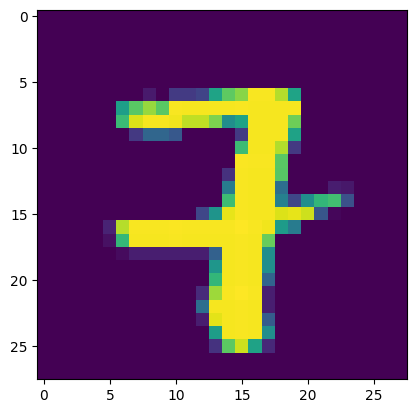

In [50]:
import matplotlib.pyplot as plt

class_index = 7
train_loader_class = train_loaders[class_index]

plt.imshow(next(iter(train_loader_class))[0][0,0])

In [68]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # Ajouter la perte sur l'ensemble des données de test
            pred = output.argmax(dim=1, keepdim=True)  # Trouver la classe prédite
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    # print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
    #       f'({accuracy:.2f}%)\n')
    return accuracy

In [75]:
device = torch.device("mps")
model.to(device)

test_scores = {}
for class_index in range(10):
    test_loader_class = test_loaders[class_index]
    test_scores[class_index] = test(model, device, test_loader_class)

test_scores

{0: 99.38775510204081,
 1: 99.64757709251101,
 2: 99.03100775193798,
 3: 98.41584158415841,
 4: 98.57433808553971,
 5: 98.54260089686099,
 6: 98.64300626304802,
 7: 98.44357976653697,
 8: 97.53593429158111,
 9: 96.33300297324084}

In [74]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")


tensor([1.], device='mps:0')
